# How to use fuvpy

fuvpy is a collection of functions to analyse and visualize auroral images generated with fuview3 (or xvis).
The images are stored in xarray.Dataset variables, so xarray must be installed.  
This is very much a work in progress, so the code might change considerably in the semi-near future.

Images are loades as follows:

In [1]:
import pysymmetry.fuvpy as fuv
import pandas as pd
import glob
import warnings
import matplotlib.pyplot as plt
from pysymmetry.visualization.polarsubplot import Polarsubplot

# %matplotlib notebook

warnings.filterwarnings("ignore",category =RuntimeWarning) # Turn of all the warnings when np.where contains NaNs. Should modify the source code to avoid this. 
path = '../data/processed/fuv20010528/wic/'
wicfiles = glob.glob(path + '*.sav')
wic = fuv.readFUVimage(wicfiles)
wic

<xarray.Dataset>
Dimensions:     (col: 256, date: 9, row: 256)
Coordinates:
  * date        (date) datetime64[ns] 2001-05-28T03:29:46 ... 2001-05-28T03:46:07
Dimensions without coordinates: col, row
Data variables:
    image       (date, row, col) float32 2226.7175 2243.6506 ... 0.0 0.0
    mlat        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    mlon        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    mlt         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    glat        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    glon        (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    dza         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    sza         (date, row, col) float32 nan nan nan nan nan ... nan nan nan nan
    hemisphere  (date) <U5 'north' 'north' 'north' ... 'north' 'north' 'north'
    id          <U3 'WIC'
    bad         (row, col) bool False False False False ... False False False

Two different ways to select and plot the images

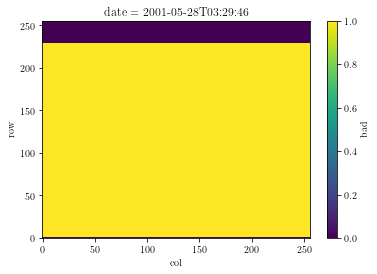

In [13]:
wic.sel(date='2001-05-28 03:29:46')['bad'].plot()

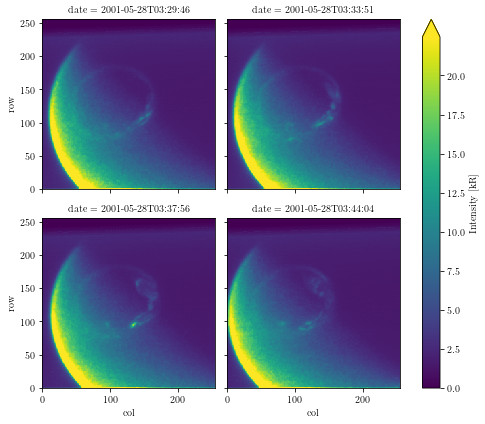

In [3]:
wic = fuv.getFUVrayleigh(wic)
wic.isel(date=[0,2,4,7])['imageR'].plot(x='col', y='row', col='date', col_wrap=2,robust=True)

In the same way we can visualize for instance the viewing anlge for these images:

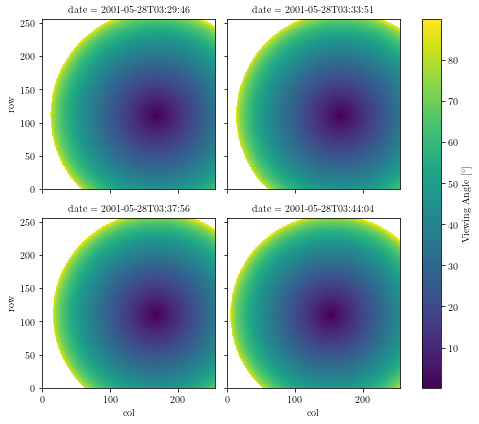

In [4]:
wic.isel(date=[0,2,4,7])['dza'].plot(x='col', y='row', col='date', col_wrap=2)

Note how the name and units of the variables appear automatically in the figures. They are added to each variable, and can be accessed (and assigned) using wic['nameofvariable'].attrs.

A routine to plot the images in polar coordinates has been added to the Polarsubplot class.
Here is an example of how to use it:

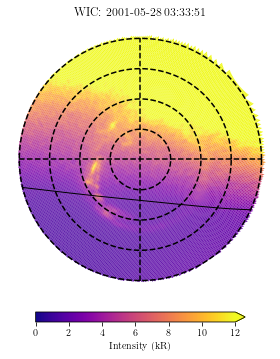

In [5]:
fig = plt.figure(figsize=(4,5))
ax = plt.subplot2grid((10, 1), (0, 0),rowspan=9)
pax = Polarsubplot(ax)
pax.showFUVimage(wic.isel(date=2),'imageR',crange=(0,12),cmap='plasma')
pax.plot_terminator(pd.to_datetime(wic['date'].values[2]))

cax = plt.subplot2grid((10, 10), (9, 1),rowspan=1,colspan=8)
cax.axis('off')
cbar = plt.colorbar(pax.ax.collections[0],orientation='horizontal',ax=cax,fraction=1,extend='max')
cbar.set_label('{} ({})'.format(wic['imageR'].attrs['long_name'],wic['imageR'].attrs['units']))

ax.set_title(wic['id'].values.tolist() + ': ' + 
             wic.isel(date=2)['date'].dt.strftime('%Y-%m-%d %H:%M:%S').values.tolist())
# It should really be possible to simplify this line
plt.tight_layout()

The temperature, voltage and flat-field correction of WIC has a tendency to give a higher offset at the top and bottom of the detector. This offset can be estimated and corrected. The method in fuvpy uses a static Bspline fit.

96.97219396109301 15.374010756505182
96.97877321746856 1.276395826182096
96.97918576009296 0.13827150866524132
96.97920731997172 0.018568534129230433
96.9792078089758 0.002939041566391476


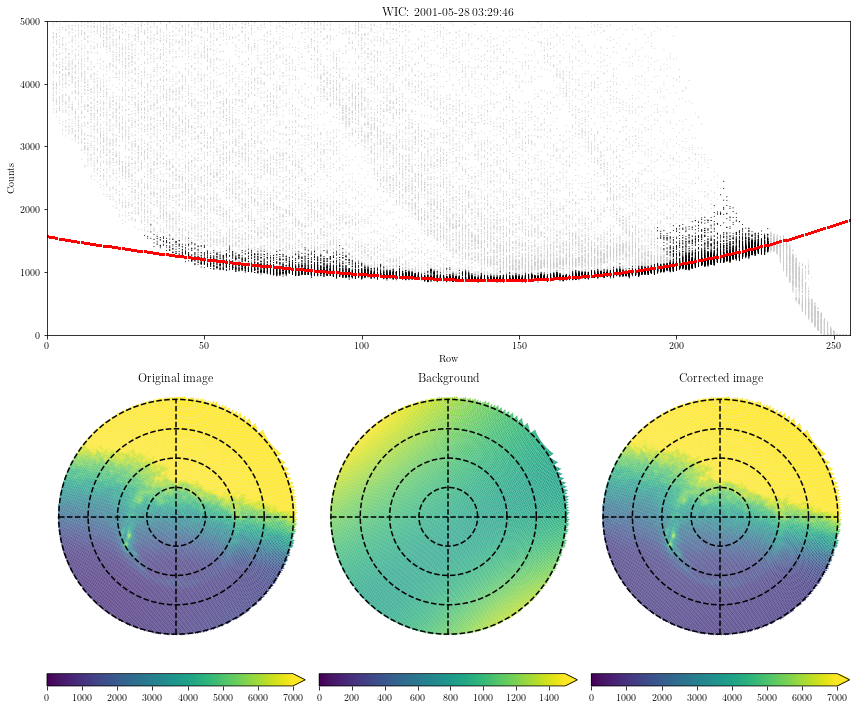

In [6]:
wic = fuv.makeWICbackgroundModel(wic)
fuv.showWICbackgroundModel(wic.isel(date=0))

Time to remove the dayglow, using the offset-corrected image. Going retro, we also use the colormap from the IMAGE mission. The simplest method is described in the appendix in *Ohma et al.* (2018), but more advanced functional forms and the possibility to dampen the temporal terms in the fit are supported in the code. The value of the parameters used to make the dayglow model are stored as attributes in the dataset.

287.86825039102274 553.640527980251
287.89494309409577 315.23165247979136
287.97174413429104 147.87466712443916
288.00430907638804 64.63844490101363
288.01573227438263 27.74451008964918
288.0195565839201 12.08808854762085
288.020829159686 5.278358930851858
288.02125476090276 2.357755538404014
288.02139827183294 1.0818058023107355
288.02144717612117 0.5111996836504975
288.0214640487044 0.24909371818871767
288.02146995825717 0.12517044783753997
288.021472063808 0.06480391719509485
288.021472828751 0.03450177211519957
288.02147311274877 0.018839595807751706
288.0214732207074 0.010517903640859473
288.02147326278595 0.005983371021550563


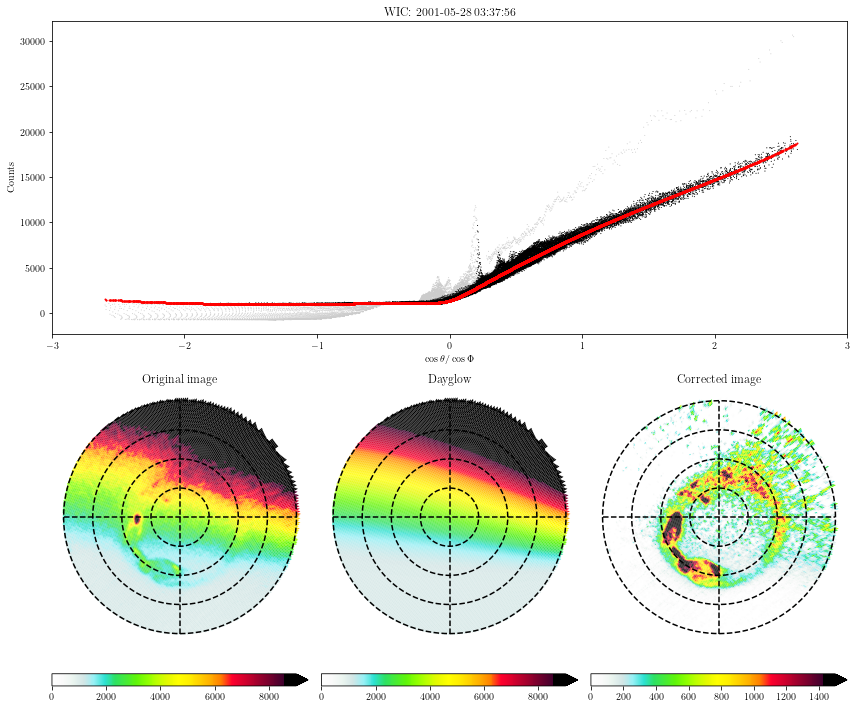

{'inImg': 'dimage',
 'outImg': 'cimage',
 'model': ('exp', 0.15),
 'order': 3,
 'damingVal': 0,
 'stop': 0.01,
 'auroralZone': (60, 80),
 'minlat': 0,
 'dzalim': 80,
 'knots': array([-3. , -3. , -3. , -3. , -0.2,  0. ,  0.2,  1. ,  2. ,  3. ,  4. ,
         4. ,  4. ,  4. ])}

In [14]:
wic = fuv.makeFUVdayglowModel(wic.isel(date=[2,3,4]),inImg='dimage',model=('exp',0.15))
fuv.showFUVdayglowModel(wic.isel(date=2),cmap=fuv.getIMAGEcmap())
wic.attrs['dayglowModel']

The images can also be plotted in an mlt-mlat projection. If there is any interest, this function can be expanded to also do mlon-mlat and glon-glat projections.

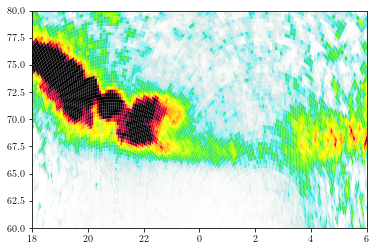

In [8]:
fuv.showFUVimageProjection(wic.isel(date=2),inImg='cimage',crange=(0,1500),cmap=fuv.getIMAGEcmap())

The images can be fairly noisy, and it can be necessary to filter them in order to process them further.
This can be done by e.g. the opencv package

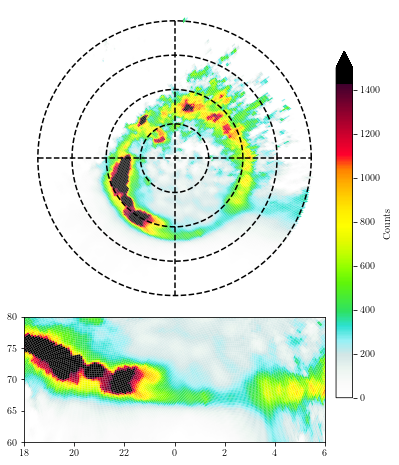

In [9]:
import cv2
import matplotlib.pyplot as plt

wic = fuv.filterFUVimage(wic,'cimage','fimage',cv2.bilateralFilter,9,250,6)

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot2grid((10, 10), (0, 0),rowspan=7,colspan=9)
pax = Polarsubplot(ax1)
pax.showFUVimage(wic.isel(date=2),'fimage',crange=(0,1500),cmap=fuv.getIMAGEcmap())

ax2 = plt.subplot2grid((10, 10), (7, 0),rowspan=3,colspan=9)
fuv.showFUVimageProjection(wic.isel(date=2),inImg='fimage',crange=(0,1500),cmap=fuv.getIMAGEcmap(),ax=ax2)

cax = plt.subplot2grid((10, 100), (1, 93),rowspan=8,colspan=7)
cax.axis('off')
cbar = plt.colorbar(pax.ax.collections[0],ax=cax,fraction=1,extend='max')
cbar.set_label(wic['fimage'].attrs['long_name'])

Currently, two approaches to identifying the open-closed boundary (ocb) are included. Both methods divide the image into 48 1-hr wide overlapping mlt sectors. 

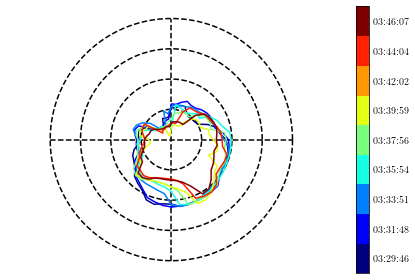

In [10]:
b = fuv.findBoundaries(wic,inImg='fimage',countlim=400,method='medianIntensityLocation',eqa=63,cap=89)
fuv.plotOCBtimeseries(b)
flux = fuv.calculateflux(b)

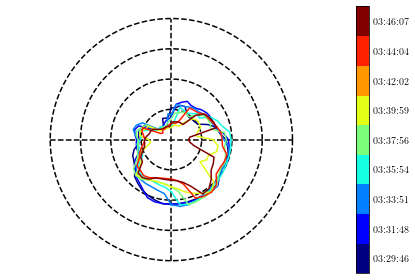

In [11]:
b = fuv.findBoundaries(wic,inImg='fimage',countlim=400,method='pcLimit',eqa=63,cap=86)
fuv.plotOCBtimeseries(b)

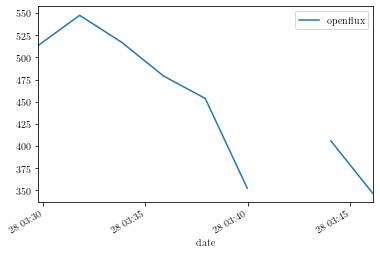

In [15]:
flux.plot()